In [14]:
using Distributions
using StatsBase
using PythonPlot
using DataFrames
using Optim
using NLsolve
using Setfield
using CSV
include("estimators.jl")
include("rem_theory.jl")

FIG_PATH = "/Users/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/Finite Lineages Plos Journal/paper/figures"

"/Users/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/Finite Lineages Plos Journal/paper/figures"

# Setup

In [15]:
cmap = get_cmap("plasma");

## Theory from REM

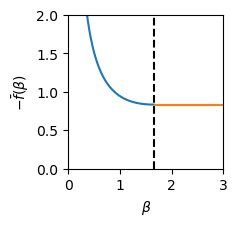

In [16]:
# first we just plot the free energy of the REM to see of the formulas make sense
βrng = collect(0.1:0.01:2*βc)
fig,ax = subplots(figsize=(2,2))
ax.plot(βrng[βrng .< βc],-fed_rem_ht.(βrng[βrng .< βc]))
ax.plot(βrng[βrng .> βc],-fed_rem_lt.(βrng[βrng .> βc]))
ax.vlines([βc],0,2,color="k",linestyle="--")
ax.set_ylim([0,2])
ax.set_xlim([0,3])
ax.set_ylabel(L"$-\bar{f}(\beta)$")
ax.set_xlabel(L"$\beta$")
fig

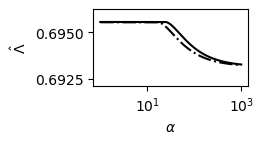

In [17]:
include("rem_theory.jl")
# compute theoretical predictions for Λ based on REM
θ = (n = 5,M = 20,t = 10, τ0=1,σ=0.1,α=0.03,c=0)
αrng_theory = collect(1.:0.2:1000);
Lhats_theory = [Lhat_rem_theory(@set θ.α = a) for a in αrng_theory];
Lhats_theory2 = [Lhat_rem_theory2(@set θ.α = a) for a in αrng_theory];
Ltrue = 2log(2)/(1+sqrt(1-2log(2)*θ.σ^2))

fig, ax= subplots(figsize=(2,1))
ax.semilogx(αrng_theory,Lhats_theory2,"k-.",label=L"$\tilde{\Lambda}_{\rm REM}$")
ax.semilogx(αrng_theory,Lhats_theory,"k-",label=L"$\tilde{\Lambda}_{\rm REM}$")
ax.set_ylim(0.995*Ltrue,1.001*Ltrue)
ax.set_xlabel(L"$\alpha$")
ax.set_ylabel(L"$\hat{\Lambda}$")
fig

# Load Simulated data

In [18]:
FDE_data = CSV.read("./output/df_FDE",DataFrame);
Mrng_FDE = unique(FDE_data[:,end]);
αrng_FDE = CSV.read("./output/alpha_FDE",DataFrame).alpha;

FTE_data = CSV.read("./output/df_FTE",DataFrame);
Mrng_FTE = unique(FTE_data[:,end]);
αrng_FTE = CSV.read("./output/alpha_FTE",DataFrame).alpha;

Lhats_FDE = [Matrix(df[:,1:length(αrng_FDE)]) for df in groupby(FDE_data,length(αrng_FDE)+1)];
Lhats_FTE = [Matrix(df[:,1:length(αrng_FTE)]) for df in groupby(FTE_data,length(αrng_FTE)+1)];

# take mean and variance
Lhats_FDE_med = [median(y,dims=1)[1,:] for y in Lhats_FDE];
Lhats_FDE_var = [var(y,dims=1)[1,:] for y in Lhats_FDE];
Lhats_FTE_med = [median(y,dims=1)[1,:] for y in Lhats_FTE];
Lhats_FTE_var = [var(y,dims=1)[1,:] for y in Lhats_FTE];



# Make Figure 3

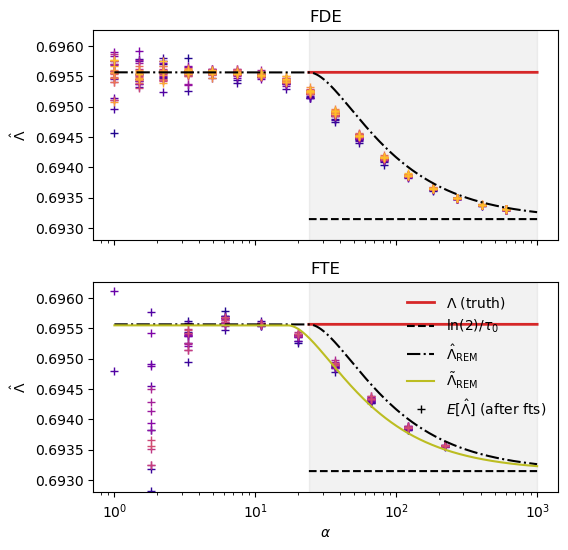

In [20]:
fig, axs= subplots(figsize=(6,6),sharex=true,nrows=2)


#axs[0].plot(αrng_FDE,Lhats_FDE[1]',"k.",alpha=0.5,lw=0.1,markersize=0.4)
for k in 1:length(Lhats_FDE_med)
    axs[0].plot(αrng_FDE,Lhats_FDE_med[k],"+",color = cmap(k/(length(Lhats_FDE_med)+5)))
end


#axs[1].plot(αrng_FTE,Lhats_FTE[end]',"k.",alpha=0.5,lw=0.1,markersize=0.4)


αc = βc/(Ltrue*θ.σ)

intercepts = []
slopes = []
for k in 1:length(Lhats_FTE_med)
    #axs[1].plot(αrng_FTE,Lhats_FTE_med[k],"-",color = cmap(k/(length(Lhats_FDE_med)+5)),alpha=0.2,lw=0.3)


    # finite-size scaling


    y = log.(median(Lhats_FTE[k]',dims=2)[αrng_FTE.< αc/2] .- Ltrue)
    X = hcat(ones(length(y)),log.(αrng_FTE[αrng_FTE.< αc/2]))
    inter,slope = X\y
    xrng_scaling = log.(collect(αrng_FTE[1]:0.01:αrng_FTE[end]))
    push!(intercepts,inter)
    push!(slopes,slope)
    axs[1].plot(αrng_FTE,Lhats_FTE_med[k] .- exp.(inter) .* αrng_FTE .^slope ,"+",color = cmap(k/(length(Lhats_FDE_med)+5)))

end

y = log.(median(Lhats_FTE[1]',dims=2)[αrng_FTE.< αc/2] .- Ltrue)
X = hcat(ones(length(y)),log.(αrng_FTE[αrng_FTE.< αc/2]))
inter,slope = X\y
xrng_scaling = log.(collect(αrng_FTE[1]:0.01:αrng_FTE[end]))
#axs[1].plot(exp.(xrng_scaling),exp.(slope .*xrng_scaling .+ inter) .+ Ltrue,"C7-",lw=2,label=L"$\sim 1/\alpha$")



# ----------------------------------------------------------------------------------------
# axis stuff
ymin,ymax = 0.9995*log(2),1.001*Ltrue
axs[0].set_ylim(ymin,ymax)
axs[1].set_ylim(ymin,ymax)
axs[0].set_title("FDE")
axs[1].set_title("FTE")

# ----------------------------------------------------------------------------------------
# indicate limiting behavior

for ax in axs
    ax.plot(αrng_theory[αrng_theory .> αc],ones(length(αrng_theory[αrng_theory .> αc])) .* Ltrue,"C3",label=L"$\Lambda$ (truth)",lw=2)
    ax.plot(αrng_theory[αrng_theory .> αc],ones(length(αrng_theory[αrng_theory .> αc])) .* log(2),"k--",label=L"$\ln(2)/\tau_0$")
    ax.semilogx(αrng_theory,Lhats_theory,"k-.",label=L"$\hat{\Lambda}_{\rm REM}$")
    ax.set_ylabel(L"$\hat{\Lambda}$")

    
    ax.axvspan(αc,αrng_theory[end], alpha=0.05, color="k")
end
axs[1].set_xlabel(L"$\alpha$")
axs[1].semilogx(αrng_theory,Lhats_theory2,"C8-",label=L"$\tilde{\Lambda}_{\rm REM}$")

axs[1].plot([],"k+",label=L"$E[\hat{\Lambda}]$ (after fts)")
axs[1].legend(frameon=true,loc=1,facecolor="white",framealpha=0.0,fancybox=false,edgecolor="w")

#fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax)

savefig(FIG_PATH*"/phase_transition.pdf",bbox_inches="tight")

fig

In [37]:
CSV.write("./output/fig4_FTE_fits.csv",DataFrame(Dict(:intercepts => intercepts,:slopes => slopes)))
#CSV.write("./output/fig4_FTE_slopes.csv",DataFrame(slopes))

"./output/fig4_FTE_fits.csv"

In [22]:
slopes

19-element Vector{Any}:
 -2.1254763755910084
 -2.114488666389396
 -2.1153455992812886
 -2.1921047436997134
 -2.0783994721932175
 -2.0664787153572326
 -2.1054149682099075
 -2.0839825005842605
 -2.0790455777392025
 -2.106761899349164
 -2.0969276388570526
 -2.1170763324229163
 -2.106432914473195
 -2.0925272295196877
 -2.1074489111884325
 -2.1469172433957406
 -2.099430745083187
 -2.151177184157066
 -2.1666395544665744

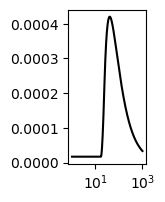

In [113]:
fig, ax= subplots(figsize=(1,2))
ax.semilogx(αrng_theory,Lhats_theory .- Lhats_theory2,"k-",label=L"$\tilde{\Lambda}_{\rm REM}$")
#ax.set_ylim(ymin,1.01*Ltrue)
fig

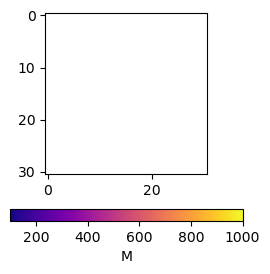

In [30]:
fig, ax= subplots(figsize=(3,3),sharey=true)
img = imshow(sqrt.(Mrng .* Mrng'), cmap=cmap)
img.set_visible(false)
c = colorbar(orientation="horizontal",label="M")
savefig(FIG_PATH*"/colorbar.pdf",bbox_inches="tight")
fig

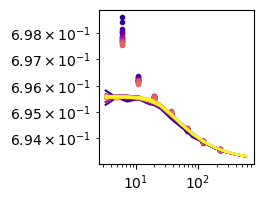

In [31]:
fig, ax= subplots(figsize=(2,2),sharey=true)
for k in 1:length(Lhats_FTE_med)
    ax.loglog(αrng_FTE[4:end],Lhats_FTE_med[k][4:end],".",color = cmap(k/length(Lhats_FDE_med)))
end

for k in 1:length(Lhats_FDE_med)
    ax.loglog(αrng_FDE[4:end],Lhats_FDE_med[k][4:end],"-",color = cmap(k/length(Lhats_FDE_med)))
end


fig

# Scaling with time

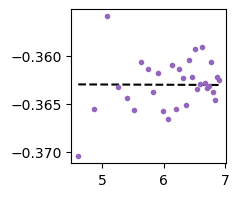

In [10]:
fig, ax= subplots(figsize=(2,2),sharey=true)
Ltrue = 2log(2)/(1+sqrt(1-2log(2)*θ.σ^2))

y = [log.(L[3]) for L in Lhats_FDE_med]
X = hcat(ones(length(y)),log.(Mrng_FDE))
inter,slope = inv(X'*X)*X'*y

ax.plot(log.(Mrng_FDE),log.(Mrng_FDE) *slope.+ inter,"k--")
ax.plot(log.(Mrng_FDE),[log.(L[3]) for L in Lhats_FDE],"C4.")
#savefig(FIG_PATH*"/phase_transition.pdf",bbox_inches="tight")
fig

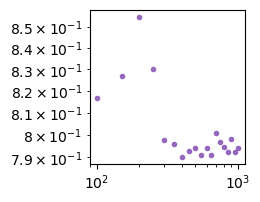

In [15]:
fig, ax= subplots(figsize=(2,2),sharey=true)
Ltrue = 2log(2)/(1+sqrt(1-2log(2)*θ.σ^2))

y = [log.(L[5]) for L in Lhats_FTE_med]
X = hcat(ones(length(y)),log.(Mrng_FTE))
inter,slope = inv(X'*X)*X'*y

#ax.plot(log.(Mrng_FTE),log.(Mrng_FTE) *slope.+ inter,"k--")
ax.loglog(Mrng_FTE,[L[5] for L in Lhats_FTE],"C4.")
#savefig(FIG_PATH*"/phase_transition.pdf",bbox_inches="tight")
fig

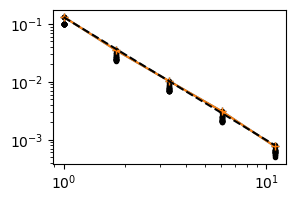

In [175]:
fig,ax = subplots(figsize=(3,2))
αc = βc/(log(2)*0.1)

k = 1
y = log.(median(Lhats_FTE[k]',dims=2)[αrng_FTE.< αc/2] .- Ltrue)
X = hcat(ones(length(y)),log.(αrng_FTE[αrng_FTE.< αc/2]))
inter,slope = X\y
ax.plot(exp.(X[:,2]),exp.(y),"+-")

[ax.loglog(αrng_FTE[αrng_FTE.< αc/2],median(Lhats_FTE[k]',dims=2)[αrng_FTE.< αc/2] .- Ltrue,"k.",) for k in 1:length(Mrng_FTE)]
#ax.loglog(X[:,2],y,".-")
ax.plot(exp.(X[:,2]),exp.(y),"+-")
ax.plot(exp.(X[:,2]),exp.(inter) .* exp.(X[:,2]) .^ slope,"k--")
fig